# Compute reference embeddings

In [1]:
from setup import neurotransmitters, model, model_size, device, feat_dim, resize_size, dataset_path, curated_idx, trans
from setup import tqdm, torch, np, os, h5py, sns, plt, tqdm, Trans, Image
from setup import cosine_similarity, euclidean_distances
from perso_utils import get_fnames, load_image, get_latents
from DINOSim import DinoSim_pipeline, diplay_features
from napari_dinosim.utils import get_img_processing_f

# Create an instance of the pipeline (not just assigning the class)
few_shot = DinoSim_pipeline(model,
                            model.patch_size,
                            device,
                            get_img_processing_f(resize_size),
                            feat_dim, 
                            dino_image_size=resize_size
                            )

Device: cpu


Using cache found in /home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main
/home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Model loaded


In [1]:
k = 10
data_aug = True

files, labels = zip(*get_fnames()) 
good_files = [files[idx] for idx in curated_idx] 
good_labels = [labels[idx] for idx in curated_idx]

if data_aug:
    for file in good_files:
        pass
        
    
    
    datasets = [good_files[i:i+10] for i in range(0, len(curated_idx), 10)] # list of lists of files
    _labels = [good_labels[i:i+10] for i in range(0, len(curated_idx), 10)] # list of lists of labels


else:
    datasets = [good_files[i:i+10] for i in range(0, len(curated_idx), 10)] # list of lists of files
    _labels = [good_labels[i:i+10] for i in range(0, len(curated_idx), 10)] # list of lists of labels


latent_list, label_list = [], []
for dataset, batch_label in tqdm(zip(datasets, _labels), desc='Iterating through neurotransmitters'):
#for d, l in tqdm(zip(good_files, good_labels), desc='Iterating through neurotransmitters'):
    # Load images and prepare data
    images = np.array([load_image(file)[0] for file in dataset]).transpose(0,2,3,1)  # Convert to numpy array
    coordinates = [(0, load_image(file)[1], load_image(file)[2]) for file in dataset]
    # Pre-compute embeddings
    few_shot.pre_compute_embeddings(
        images,  # Pass numpy array of images
        overlap=(0.5, 0.5),
        padding=(0, 0),
        crop_shape=(512, 512, 1),
        verbose=True,
        batch_size=1
    )
    
    # Set reference vectors
    few_shot.set_reference_vector(coordinates, filter=None)
    ref = few_shot.get_refs()
    
    # Get closest elements - using the correct method name
    
    close_embedding =  few_shot.get_k_closest_elements(k=k)
    #k_labels = [l for _ in range(k)]
    k_labels =  [batch_label[0] for _ in range(k)]

    
    # Convert to numpy for storing
    close_embedding_np = close_embedding.cpu().numpy() if isinstance(close_embedding, torch.Tensor) else close_embedding
    
    latent_list.append(close_embedding_np)
    label_list.append(k_labels)
    
    # Clean up to free memory
    few_shot.delete_precomputed_embeddings()
    few_shot.delete_references()
    
mean_ref = torch.from_numpy(np.vstack([np.mean(list, axis=0) for list in latent_list]))
# Stack all embeddings and labels
ref_latents = np.vstack(latent_list)
ref_labels = np.hstack(label_list)

Device: cpu


Using cache found in /home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main
/home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/tomwelch/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_reg4_pretrain.pth" to /home/tomwelch/.cache/torch/hub/checkpoints/dinov2_vitg14_reg4_pretrain.pth


100%|██████████| 4.23G/4.23G [00:39<00:00, 116MB/s] 


Model loaded


Iterating through neurotransmitters: 0it [00:00, ?it/s]

Precomputing embeddings


100%|██████████| 40/40 [00:30<00:00,  1.31it/s]
Iterating through neurotransmitters: 1it [00:31, 31.17s/it]

Precomputing embeddings


100%|██████████| 40/40 [00:34<00:00,  1.16it/s]
Iterating through neurotransmitters: 2it [01:06, 33.47s/it]

Precomputing embeddings


100%|██████████| 40/40 [00:32<00:00,  1.23it/s]
Iterating through neurotransmitters: 3it [01:39, 33.34s/it]

Precomputing embeddings


100%|██████████| 40/40 [00:35<00:00,  1.13it/s]
Iterating through neurotransmitters: 4it [02:15, 34.48s/it]

Precomputing embeddings


100%|██████████| 40/40 [00:35<00:00,  1.13it/s]
Iterating through neurotransmitters: 5it [02:51, 35.04s/it]

Precomputing embeddings


100%|██████████| 40/40 [00:35<00:00,  1.13it/s]
Iterating through neurotransmitters: 6it [03:27, 34.63s/it]


# Compute new image's embeddings

In [2]:
new_image_index = 650

img = np.array(load_image(files[new_image_index])[0])[...,np.newaxis]#.transpose(0,2,3,1)
    
few_shot.pre_compute_embeddings(
        img,  # Pass numpy array of images
        overlap=(0.5, 0.5),
        padding=(0, 0),
        crop_shape=(140, 140, 1),
        verbose=True,
        batch_size=1
    )
    
new_img_embs = few_shot.get_embs().reshape(-1, feat_dim)
    
new_label = ['new' for _ in range(new_img_embs.shape[0])]
    
# Stack all embeddings and labels
ref_latents = np.vstack(latent_list)
ref_labels = np.hstack(label_list)
    
mean_ref = np.vstack([np.mean(list, axis=0) for list in latent_list])
mean_labs = [neurotransmitter for neurotransmitter in neurotransmitters]
    
latents = np.vstack([ref_latents, new_img_embs])  # Changed from stack to vstack for proper concatenation
labs = np.hstack([ref_labels, new_label])    # Changed from stack to hstack for proper concatenation

Precomputing embeddings


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


In [3]:
print(f'The actual EM belongs to the class: {labels[new_image_index]}')
print(f'We have {len(latent_list[0])} reference points inside each of the {len(neurotransmitters)} classes')
print(f'There are {len(mean_ref)} average reference embeddings and {len(ref_latents)} in total')

The actual EM belongs to the class: dopamine
We have 10 reference points inside each of the 6 classes
There are 6 average reference embeddings and 60 in total


# Reference embeddings visualization

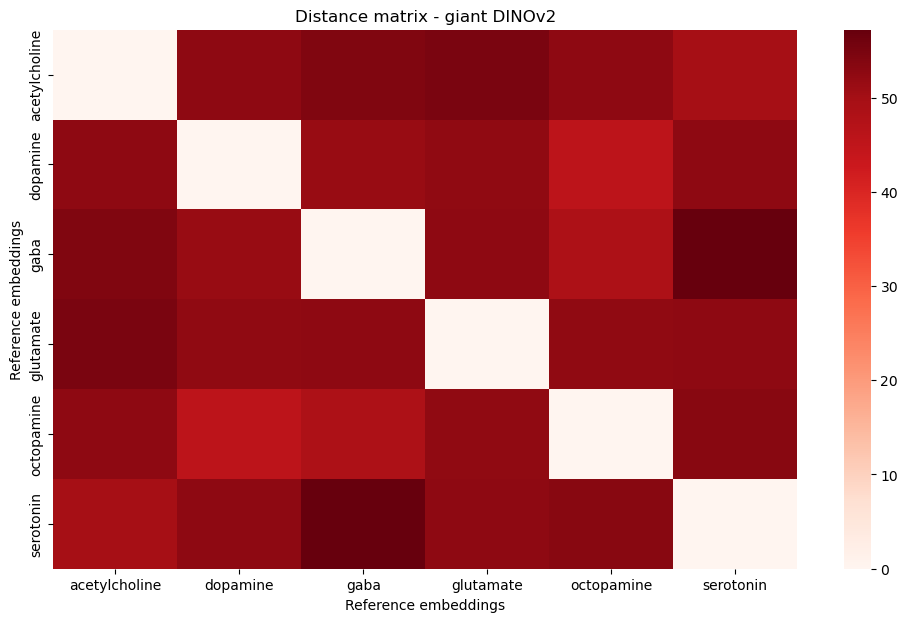

In [80]:
model_size = 'giant'
distance_matrix = euclidean_distances(mean_ref, mean_ref)
plt.figure(figsize=(12,7), dpi=100)
sns.heatmap(distance_matrix, xticklabels=mean_labs, yticklabels=mean_labs, cmap='Reds')
plt.title(f'Distance matrix - {model_size} DINOv2 - Data augmentation: {data_aug}')
plt.xlabel('Reference embeddings')
plt.ylabel('Reference embeddings')
plt.show()

In [81]:
print(f'The sum of distances is {np.sum(np.triu(distance_matrix, k=0))}')

The sum of distances is 782.523681640625


In [5]:
diplay_features(
        np.vstack([ref_latents, np.vstack(mean_ref)]),
        np.hstack([ref_labels, np.hstack(mean_labs)]),

        include_pca=False,
        pca_nb_components=100,
        clustering=False,
        nb_clusters=6,
        nb_neighbor=10,
        min_dist=1,
        nb_components=2,
        metric='cosine'
    )

/home/tomwelch/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


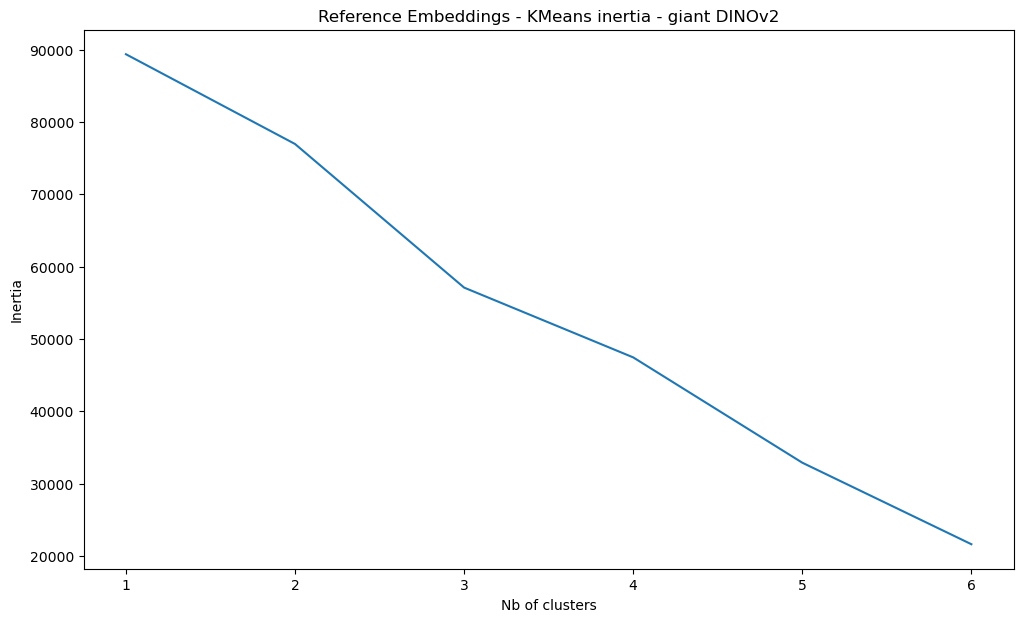

In [6]:
from sklearn.cluster import KMeans
inertia_list = []
for k in range(1,len(mean_labs)+1):
    kmeans = KMeans(n_clusters=k).fit(ref_latents)
    inertia_list.append(kmeans.inertia_)
plt.figure(figsize=(12,7),dpi=100)
plt.plot([i for i in range(1,len(mean_labs)+1)], inertia_list)
plt.title(f'Reference Embeddings - KMeans inertia - {model_size} DINOv2 - Data augmentation: {data_aug}')
plt.ylabel('Inertia')
plt.xlabel('Nb of clusters')
plt.show()

# Results 

In [7]:
diplay_features(
        latents,
        labs,
        include_pca=False,
        pca_nb_components=100,
        clustering=False,
        nb_clusters=6,
        nb_neighbor=30,
        min_dist=1,
        nb_components=2,
        metric='cosine'
    )

/home/tomwelch/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



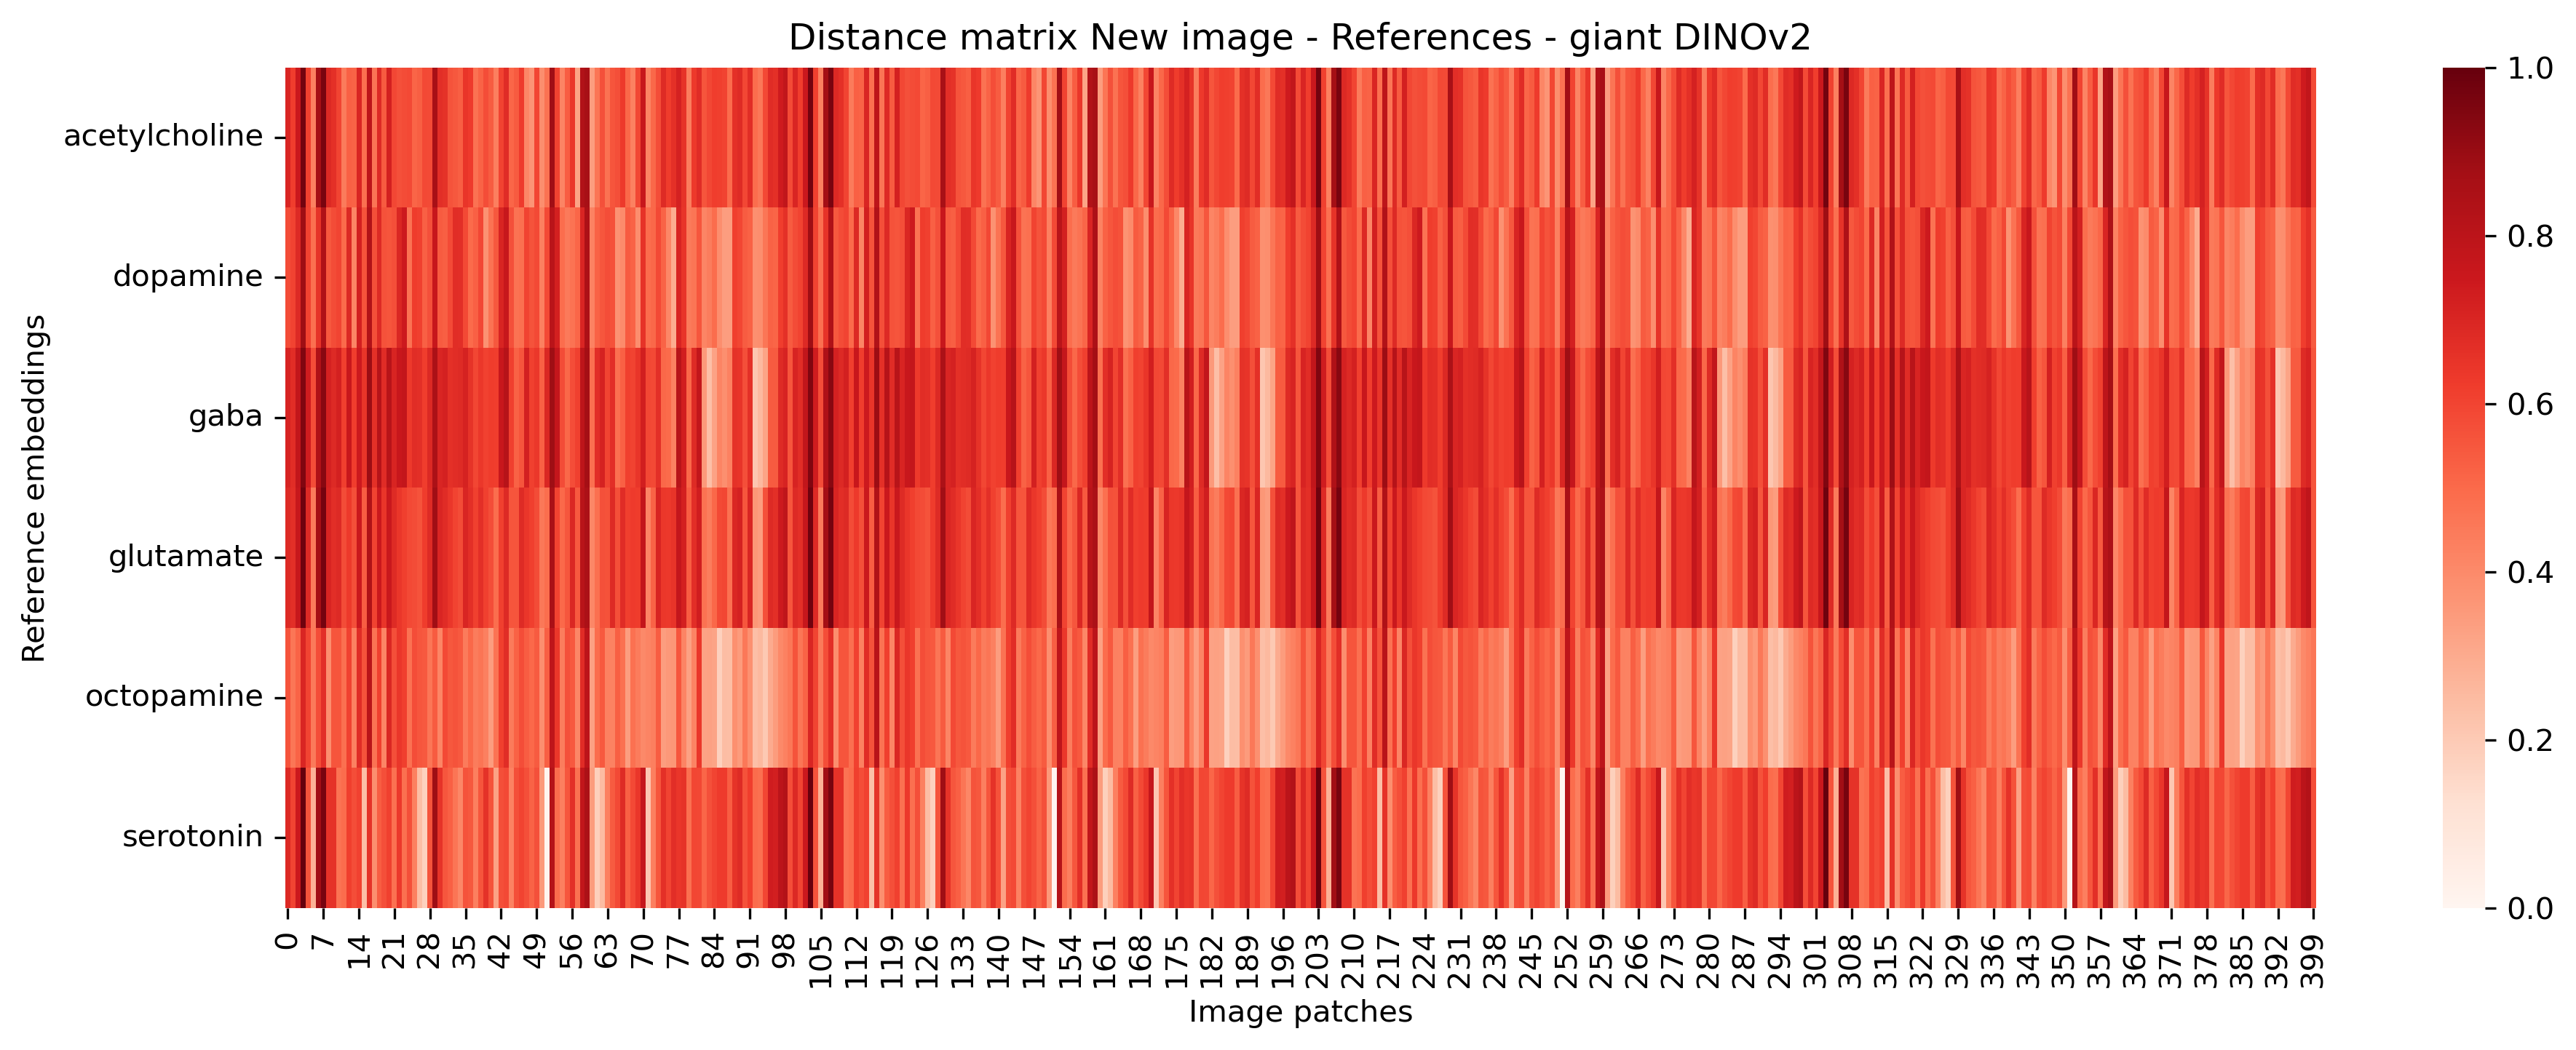

In [8]:
test_similarity_matrix = euclidean_distances(mean_ref, new_img_embs)
test_similarity_matrix_normalized = (test_similarity_matrix - np.min(test_similarity_matrix)) / (np.max(test_similarity_matrix) - np.min(test_similarity_matrix))
plt.figure(figsize=(15,5),dpi=300)
sns.heatmap(test_similarity_matrix_normalized, yticklabels=mean_labs, cmap='Reds')
plt.title(f'Distance matrix New image - References - {model_size} DINOv2 - Data augmentation: {data_aug}')
plt.xlabel('Image patches')
plt.ylabel('Reference embeddings')
plt.show()

# Testing loop

In [18]:
one_hot_neurotransmitters = np.zeros((len(neurotransmitters),len(neurotransmitters))) + np.identity(len(neurotransmitters))
emb_labels = np.hstack([[labels[i+1]]*240000 for i in range(0, 3600, 600)]).reshape(-1,1)

In [75]:
new_embeddings = torch.load('Embeddings/g_embs_140_140.pt')

In [11]:
'''
images = np.array([load_image(file)[0] for file in tqdm(files, desc='Loading images')]).transpose(0,2,3,1)

few_shot.pre_compute_embeddings(
        images,  # Pass numpy array of images
        overlap=(0.5, 0.5),
        padding=(0, 0),
        crop_shape=(140, 140, 1),
        verbose=True,
        batch_size=100
        )

new_embeddings = few_shot.get_embs().reshape(-1, feat_dim)
'''

Precomputing embeddings


100%|██████████| 144/144 [1:59:23<00:00, 49.75s/it]


In [39]:
score_lists = [[],[],[],[],[],[]]

similarity_matrix = euclidean_distances(mean_ref, new_embeddings)
similarity_matrix_normalized = (similarity_matrix - np.min(similarity_matrix)) / (np.max(similarity_matrix) - np.min(similarity_matrix))

distance_threshold = 0.05
similarity_matrix_normalized_filtered = np.where(similarity_matrix_normalized <= distance_threshold, similarity_matrix_normalized, 0)

for i, label in tqdm(enumerate(emb_labels)):

    column = similarity_matrix_normalized_filtered[:,i]

    if sum(column) == 0:
        pass
    else:
        patch_wise_distances_filtered = np.where(column == 0, 1, column)

        output_class = one_hot_neurotransmitters[np.argmin(patch_wise_distances_filtered)]

        gt_index = neurotransmitters.index(label)
        ground_truth = one_hot_neurotransmitters[gt_index]
        score = np.sum(output_class*ground_truth)
        score_lists[gt_index].append(score)

1440000it [00:05, 261627.77it/s]


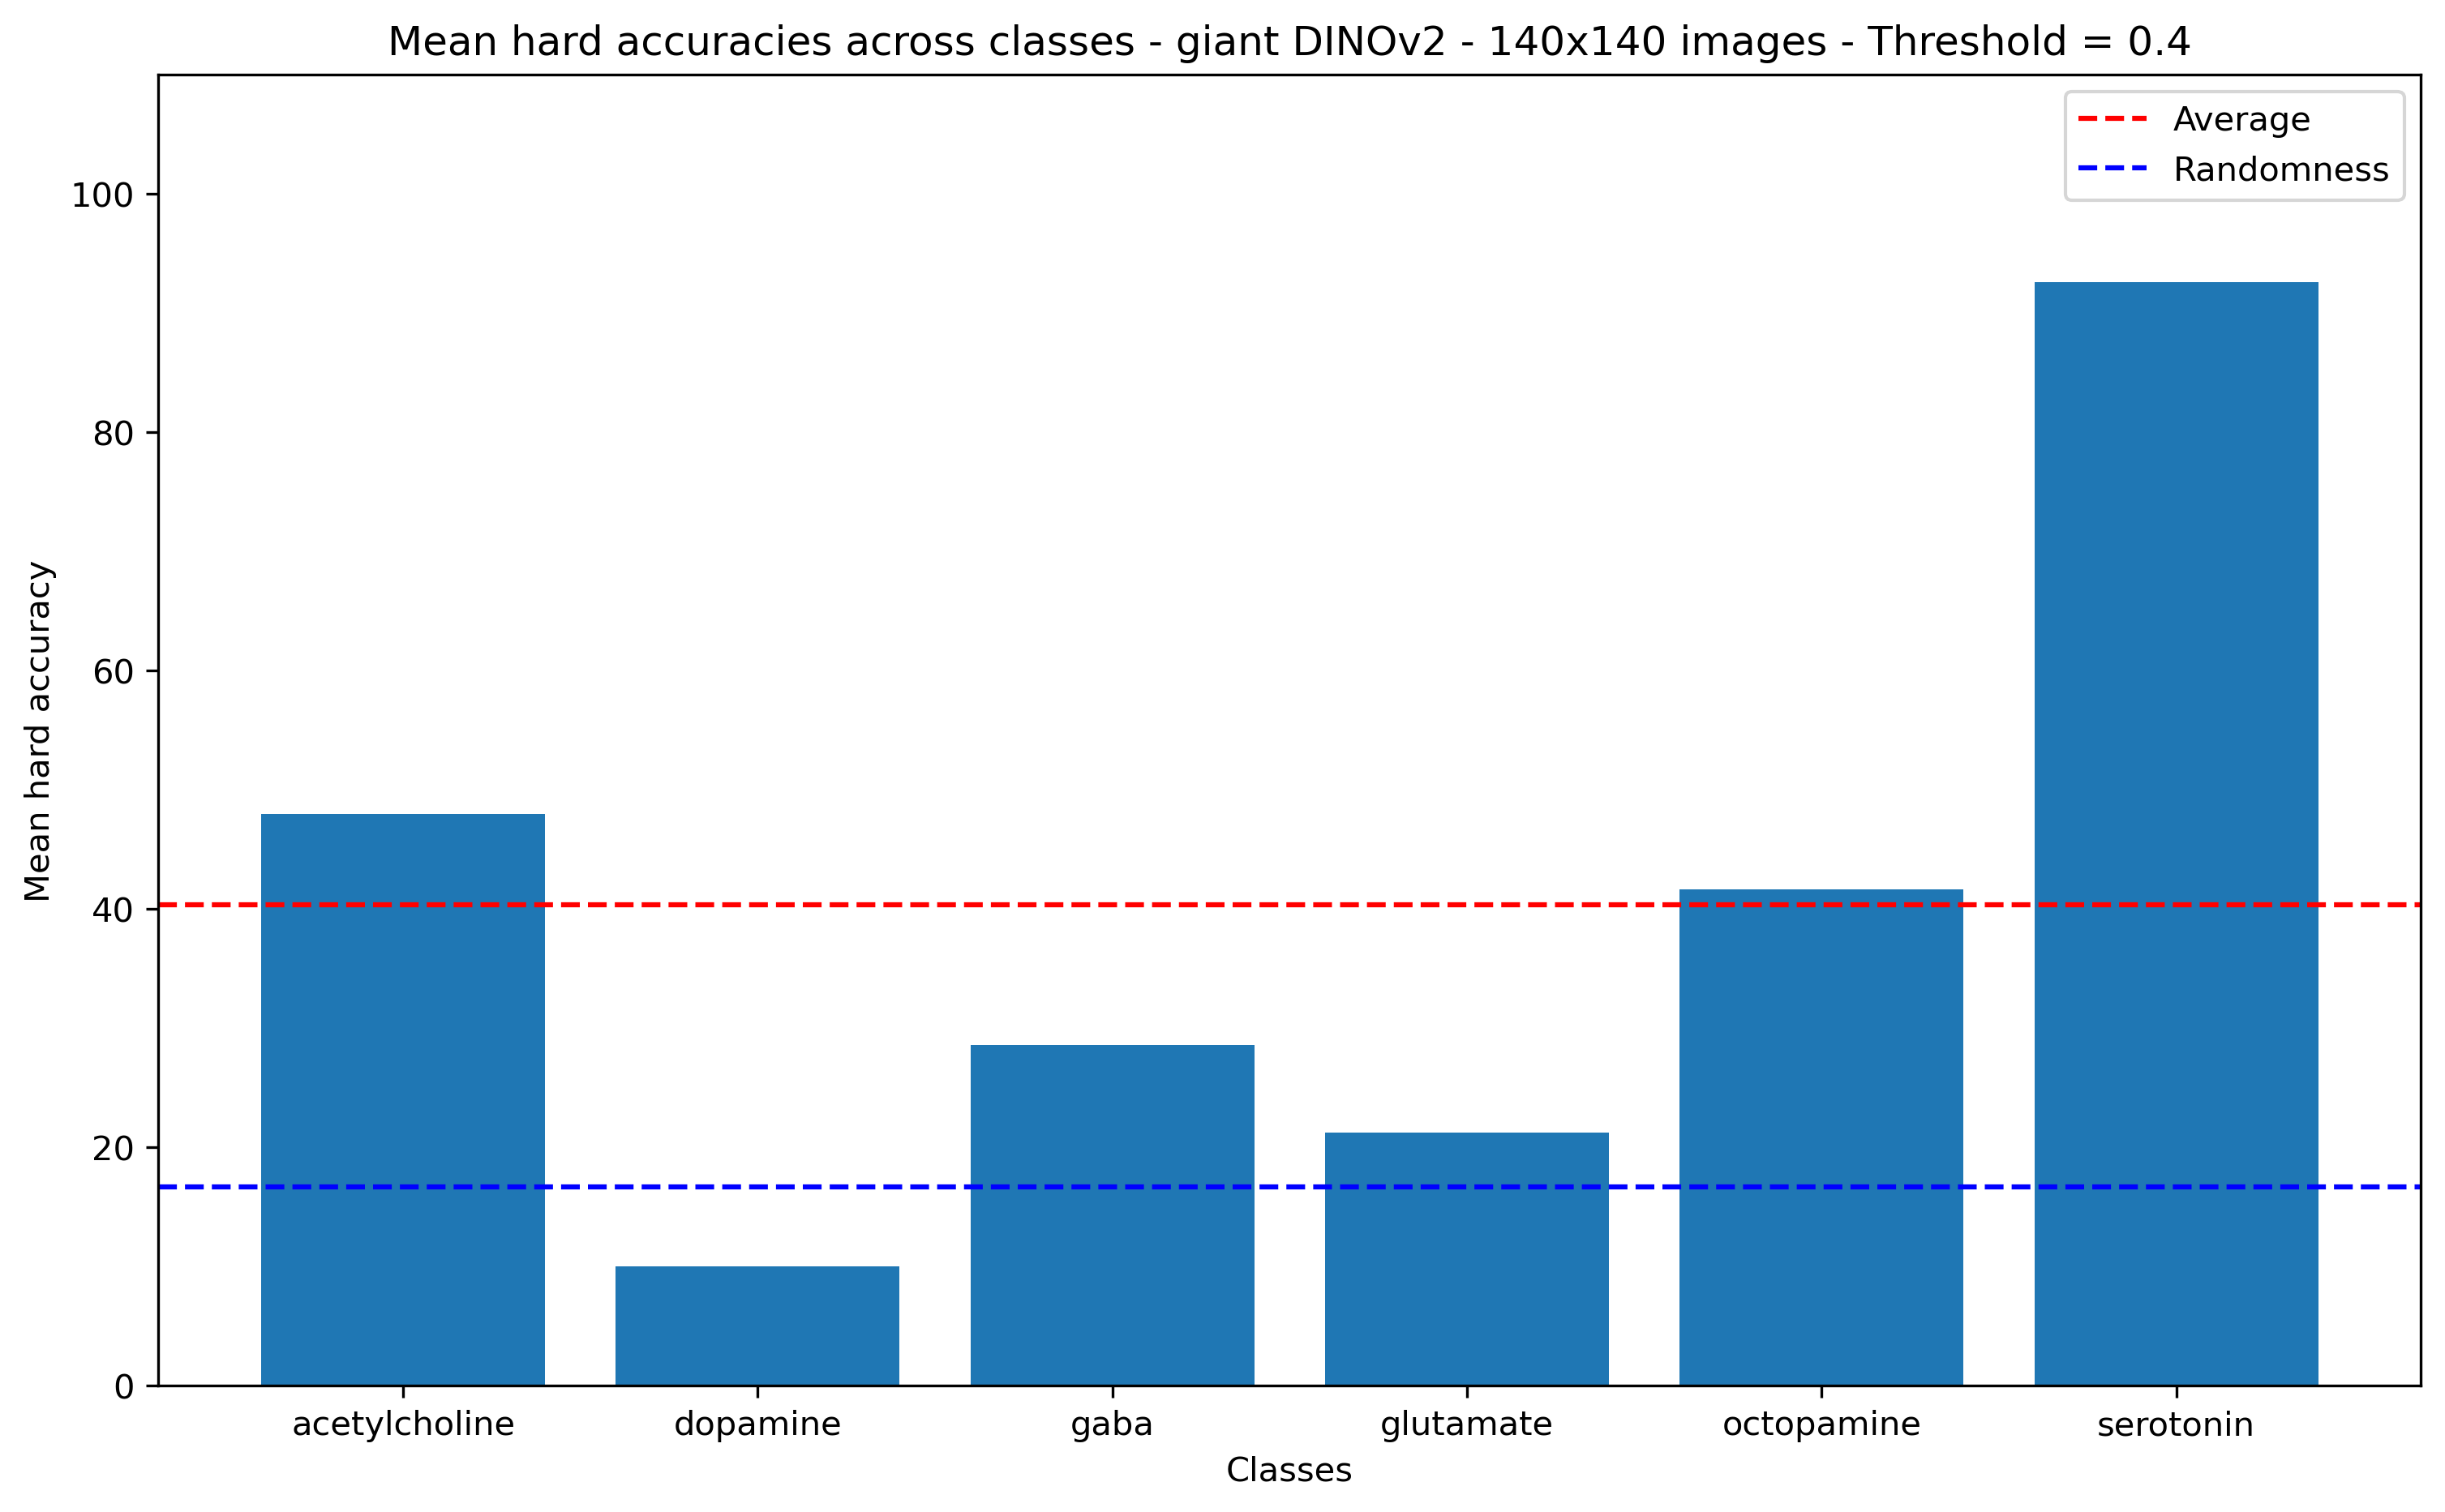

In [40]:
accuracies = [np.mean(scores)*100 for scores in score_lists]

plt.figure(figsize=(12,7), dpi=300)
plt.bar(neurotransmitters, accuracies)
plt.xlabel('Classes')
plt.ylabel('Mean hard accuracy')
plt.title(f'Mean hard accuracies across classes - {model_size} DINOv2 - 140x140 images - Threshold = {distance_threshold} - Data augmentation: {data_aug}')
plt.axhline(np.mean(accuracies), color='r', linestyle='--', label='Average')
plt.axhline(y=(100/6), color='b', linestyle='--', label='Randomness')
plt.legend()
ax = plt.gca()
ax.set_ylim([0,110])
plt.show()

In [72]:
score_lists = [[],[],[],[],[],[]]
mean_accuracies_list, included_list = [], []

similarity_matrix = euclidean_distances(mean_ref, new_embeddings)
similarity_matrix_normalized = (similarity_matrix - np.min(similarity_matrix)) / (np.max(similarity_matrix) - np.min(similarity_matrix))

for distance_threshold in tqdm(np.arange(0.05, 1.025, 0.025)): 

    similarity_matrix_normalized_filtered = np.where(similarity_matrix_normalized <= distance_threshold, similarity_matrix_normalized, 0)
    
    included_list.append(len(np.where(similarity_matrix_normalized_filtered !=0)[0]))

    for i, label in enumerate(emb_labels):

        column = similarity_matrix_normalized_filtered[:,i]

        if sum(column) == 0:
            pass
        else:
            patch_wise_distances_filtered = np.where(column == 0, 1, column)

            output_class = one_hot_neurotransmitters[np.argmin(patch_wise_distances_filtered)]

            gt_index = neurotransmitters.index(label)
            ground_truth = one_hot_neurotransmitters[gt_index]
            score = np.sum(output_class*ground_truth)
            score_lists[gt_index].append(score)

    mean_accuracies_list.append(np.mean([np.mean(scores)*100 for scores in score_lists]))
    
included_list = [inclusion*600/(400*len(files)) for inclusion in included_list]

  0%|          | 0/39 [00:00<?, ?it/s]/home/tomwelch/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/home/tomwelch/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide

100%|██████████| 39/39 [07:41<00:00, 11.84s/it]


/tmp/ipykernel_1573047/4228936473.py:6: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



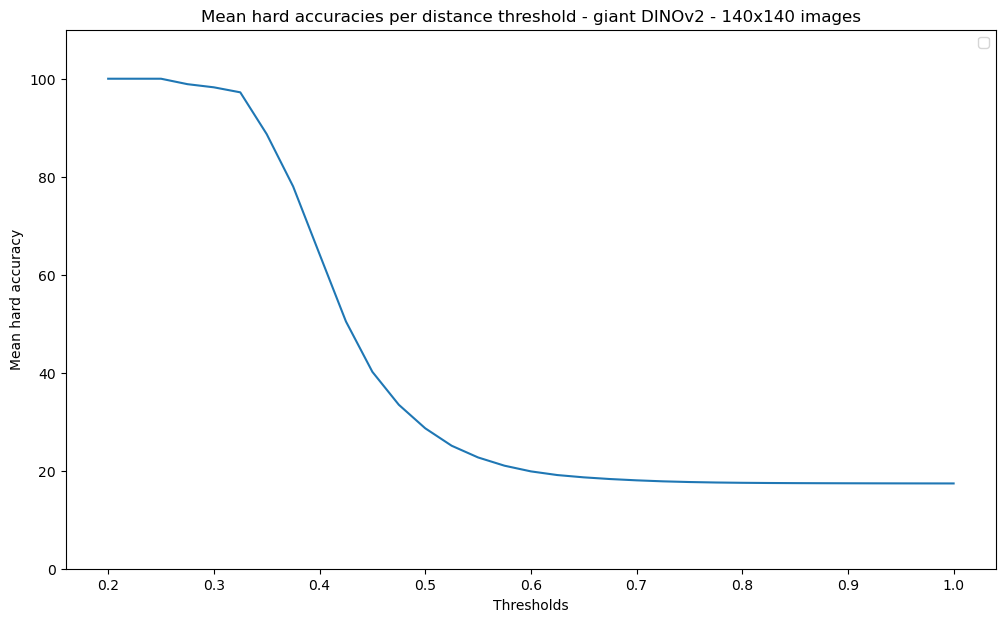

In [63]:
plt.figure(figsize=(12,7), dpi=100)
plt.plot([i for i in np.arange(0.05, 1.025, 0.025)], mean_accuracies_list)
plt.xlabel('Thresholds')
plt.ylabel('Mean hard accuracy')
plt.title(f'Mean hard accuracies per distance threshold - {model_size} DINOv2 - 140x140 images - Data augmentation: {data_aug}')
ax = plt.gca()
ax.set_ylim([0,110])
plt.show()

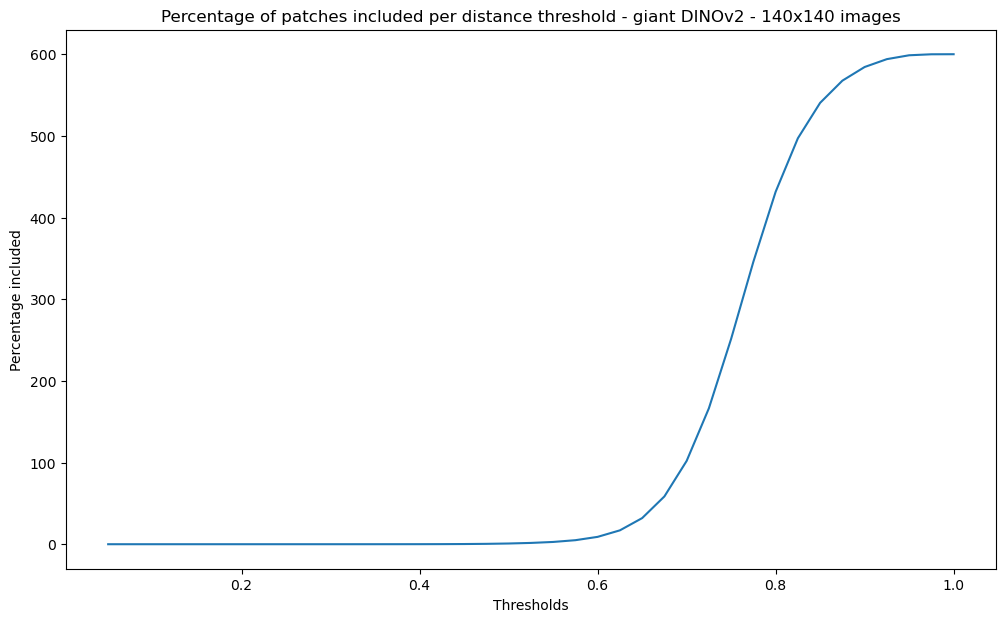

In [74]:
plt.figure(figsize=(12,7), dpi=100)
plt.plot([i for i in np.arange(0.05, 1.025, 0.025)], included_list)
plt.xlabel('Thresholds')
plt.ylabel('Percentage included')
plt.title(f'Percentage of patches included per distance threshold - {model_size} DINOv2 - 140x140 images - Data augmentation: {data_aug}')
ax = plt.gca()
ax.set_ylim([0,110])
plt.show()